# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
from torchviz import make_dot
import time

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          cost_fn_tensor, 
                                          hot_start, 
                                          hot_start_list_to_string,
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model,
                                         set_up_input_no_hot_start,
                                         )

from modules.graph_functions import plot_sine_activation

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

from modules.config import PRINT_FREQUENCY

Set up constants:

In [2]:
datalogger = MyDataLogger()
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_ml_constants_from_config()
sdl.quantum = False
sdl.noise = False # noise is for quantum, not classical
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20250928-21-59-31 - 21-59-31


Read in data, report on data read and validate distance array:

In [3]:
distance_array, sdl.best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\sim_dist_8_locs.txt.
It is known that the shortest distance is 277.2


Evaluate cost function and clear cache:

In [4]:
cost_fn = cost_fn_fact(sdl.locations, 
                       distance_array, 
                       sdl.gray, 
                       method = sdl.formulation, 
                       )
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [5]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda:0


Find problem size:

In [6]:
sdl.qubits = find_problem_size(sdl.locations, sdl.formulation)
print(f'There are {sdl.qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')

There are 14 qubits needed for 8 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [7]:
if sdl.hot_start:
    hot_start_list = hot_start(distance_array, sdl.locations)
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list = hot_start_list_to_string(hot_start_list, 
                                                sdl.locations, 
                                                sdl.gray, 
                                                sdl.formulation,
                                                )
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
    print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
    distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
    sdl.hot_start_dist = float(distance_tensor)
    print(f'The hot start distance is {sdl.hot_start_dist:.2f}, compared to a best distance of {sdl.best_dist:.2f}.')

Set up input as repeated hot start tensor calculated above:

In [8]:
if sdl.hot_start:
    unrepeated_input = bin_hot_start_list_tensor.float().to(device)
    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)
else:
    my_input, unrepeated_input = set_up_input_no_hot_start(sdl, device)

In [9]:
unrepeated_input.size()

torch.Size([1024, 14])

In [10]:
print(unrepeated_input.size())

torch.Size([1024, 14])


Set up model with gradient required:

In [11]:
#model = MyModel(sdl.qubits, 
#                sdl.layers, 
#                sdl.std_dev, 
#                cost_fn,
#                sdl.hot_start,
#                sdl.mode,
#                sdl.gradient_type,
#                ).to(device)
model = MyModel(sdl, cost_fn).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [12]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 840 parameters in total, of which 840 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True
Parameter fc3.weight requires_grad: True
Parameter fc3.bias requires_grad: True
Parameter fc4.weight requires_grad: True
Parameter fc4.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

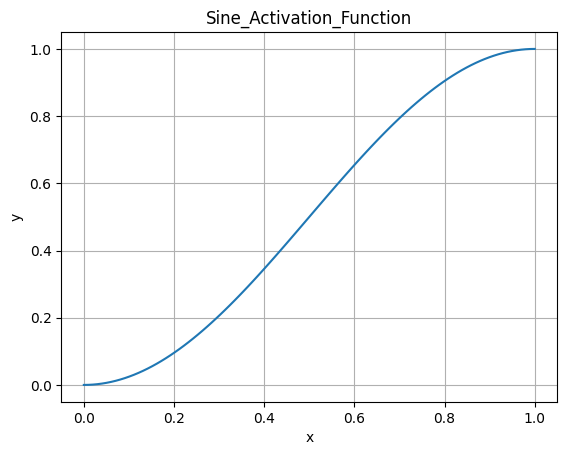

In [13]:
plot_sine_activation()

Print out model details including graph

{'fc1.weight': Parameter containing:
tensor([[ 0.0251,  0.0607, -0.0070,  0.0180, -0.0408,  0.0662,  0.0528,  0.0077,
         -0.0050, -0.0685, -0.0123, -0.0541,  0.0013, -0.0456],
        [-0.0127, -0.0692,  0.0557,  0.0431, -0.0179, -0.0288, -0.0257, -0.0507,
          0.0051, -0.0058, -0.0623, -0.0345, -0.0033, -0.0437],
        [-0.0281, -0.0309, -0.0699,  0.0600, -0.0159,  0.0017,  0.0037, -0.0484,
         -0.0204,  0.0368,  0.0670,  0.0439,  0.0080, -0.0535],
        [-0.0401, -0.0392, -0.0588, -0.0513, -0.0259,  0.0569, -0.0484, -0.0143,
          0.0029, -0.0021,  0.0614,  0.0128,  0.0137,  0.0482],
        [-0.0463, -0.0192,  0.0138,  0.0052,  0.0281, -0.0432,  0.0551,  0.0298,
          0.0130, -0.0530,  0.0556,  0.0160, -0.0296, -0.0088],
        [-0.0355,  0.0051,  0.0061,  0.0200, -0.0395,  0.0430,  0.0710,  0.0652,
         -0.0303,  0.0211, -0.0469, -0.0496, -0.0215,  0.0293],
        [ 0.0623, -0.0112, -0.0182, -0.0114, -0.0123,  0.0409, -0.0132, -0.0314,
         -0.

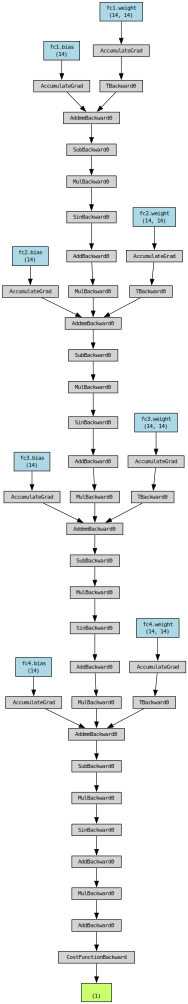

In [14]:
output = model(my_input)
lowest_cost = output.min()
filename = sdl.graph_sub_path.joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [15]:
target, criterion, optimizer = get_ready_to_train(model, 
                                                  sdl.gradient_type, 
                                                  sdl.lr, 
                                                  sdl.weight_decay, 
                                                  momentum = sdl.momentum
                                                  )

Train model and print out results:

In [16]:

t0 = time.time()
sdl.best_dist_found, sdl.iteration_found, sdl.index_list, sdl.average_list, sdl.lowest_list =\
output_data = train_model(sdl.iterations,
                          model, 
                          my_input, 
                          target, 
                          criterion,
                          optimizer,
                          print_results=True,
                          print_frequency=PRINT_FREQUENCY
                          )

sdl.average_list_all.append(sdl.average_list)
sdl.lowest_list_all.append(sdl.lowest_list)
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
sdl.elapsed = elapsed
sdl.update_cache_statistics(cost_fn)
sdl.save_results_to_csv()
sdl.save_detailed_results()

Epoch 0, Average cost: 570.000 Epoch min cost:570.000, Lowest Cost to date: 570.000
Epoch 0, fc1.weight grad: 0.00
Epoch 0, fc1.bias grad: 0.00
Epoch 0, fc2.weight grad: 0.00
Epoch 0, fc2.bias grad: 0.00
Epoch 0, fc3.weight grad: 0.00
Epoch 0, fc3.bias grad: 0.04
Epoch 0, fc4.weight grad: 0.02
Epoch 0, fc4.bias grad: 14.86
Epoch 10, Average cost: 570.000 Epoch min cost:570.000, Lowest Cost to date: 570.000
Epoch 10, fc1.weight grad: 0.00
Epoch 10, fc1.bias grad: 0.00
Epoch 10, fc2.weight grad: 0.00
Epoch 10, fc2.bias grad: 0.00
Epoch 10, fc3.weight grad: 0.00
Epoch 10, fc3.bias grad: 0.25
Epoch 10, fc4.weight grad: 0.08
Epoch 10, fc4.bias grad: 24.64
Epoch 20, Average cost: 570.000 Epoch min cost:570.000, Lowest Cost to date: 570.000
Epoch 20, fc1.weight grad: 0.00
Epoch 20, fc1.bias grad: 0.00
Epoch 20, fc2.weight grad: 0.00
Epoch 20, fc2.bias grad: 0.04
Epoch 20, fc3.weight grad: 0.01
Epoch 20, fc3.bias grad: 1.25
Epoch 20, fc4.weight grad: 0.31
Epoch 20, fc4.bias grad: 36.63
Epoch 3

In [17]:
print(f'The lowest cost found was {sdl.best_dist_found:.3f} at epoch {sdl.iteration_found}.')
print(f'The best known cost is {sdl.best_dist:.3f}')
if sdl.hot_start:
    print(f'the hot start cost was {sdl.hot_start_dist:.3f}.')

The lowest cost found was 318.600 at epoch 136.
The best known cost is 277.200


Plot loss ratio by epoch:

Graph for Run ID: 20250928-21-59-31-21-59-31 being saved to graphs\20250928-21-59-31\21-59-31.png


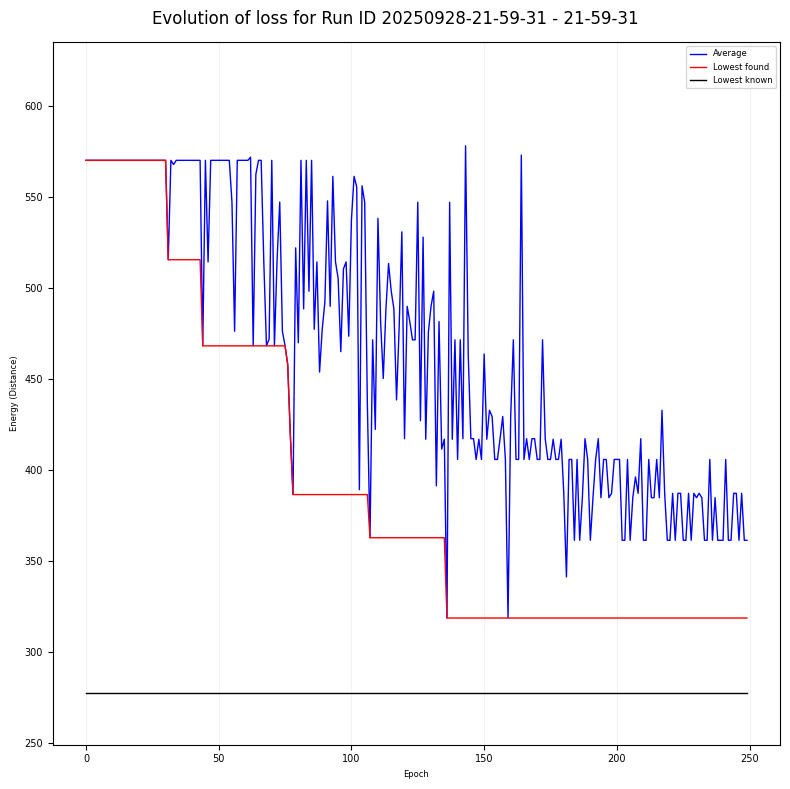

In [18]:
sdl.save_plot()


Print out parameters:

In [19]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[ 0.0251,  0.0607, -0.0070,  0.0180, -0.0408,  0.0662,  0.0528,  0.0077,
         -0.0050, -0.0685, -0.0123, -0.0541,  0.0013, -0.0456],
        [-0.0127, -0.0692,  0.0557,  0.0431, -0.0179, -0.0288, -0.0257, -0.0507,
          0.0051, -0.0058, -0.0623, -0.0345, -0.0033, -0.0437],
        [-0.0281, -0.0309, -0.0699,  0.0600, -0.0159,  0.0017,  0.0037, -0.0484,
         -0.0204,  0.0368,  0.0670,  0.0439,  0.0080, -0.0535],
        [-0.0401, -0.0392, -0.0588, -0.0513, -0.0259,  0.0569, -0.0484, -0.0143,
          0.0029, -0.0021,  0.0614,  0.0128,  0.0137,  0.0482],
        [-0.0463, -0.0192,  0.0138,  0.0052,  0.0281, -0.0432,  0.0551,  0.0298,
          0.0130, -0.0530,  0.0556,  0.0160, -0.0296, -0.0088],
        [-0.0355,  0.0051,  0.0061,  0.0200, -0.0395,  0.0430,  0.0710,  0.0652,
         -0.0303,  0.0211, -0.0469, -0.0496, -0.0215,  0.0293],
        [ 0.0623, -0.0112, -0.0182, -0.0114, -0.0123,  0.0409, -0.0132, -0.0314,
         -0.0194, -